# Are religious Americans more likely to repay loans?
The recent rise of peer-to-peer lending has been stunning. Starting from zero a few years ago, platforms like Lending Club are already placing $10 billion of unsecured personal loans per year. 

The concept is simple: a borrower fills in an application, investors choose to fund part or all of the loan, and the platform takes care of fine details, like collecting payments and annoying late borrowers. In theory, this disintermediation of banks from consumer credit lowers borrowing rates, improves investor returns, and leaves a healthy margin for the platform's profits.

The platforms publish anonymized default history from previous loans. This data helps investors make smarter decisions about future loans - attracting more investment dollars. Investors use the data to try to pick loans with a high interest rate, but a lower likelihood of default.

## Data set
For now, I will use only 36 month loans originating before 2013 (maturing before 2016). For now, I will restrict my data set to 2012 (as we go back further, the underwriting standards change). If I fill rows to handle current loans (see below), I will bring in more recent data.

## Pre-processing
The data was modified to allow robust statistical analysis:
- Religiosity was mapped from county code to county to zip code and then, finally to individual loans. This required string manipulation to build county and zip codes, plus data joins.

## Predictive factors
Many factors look to be of interest. Obvious ones include:
- FICO Score
- Debt to Income ratio
- Size of loan

Additional factors that people have provided some evidence for:
- Loan description length
  - Long descriptions are bad: http://drjasondavis.com/blog/2012/04/08/lending-club-loan-analysis-making-money-with-logistic-regression
  - Long descriptions are good: https://lendingclubmodeling.wordpress.com/2011/04/25/why-loan-descriptions-and-qa-matter/
- Loan purpose: http://blog.lendingrobot.com/research/predicting-the-number-of-payments-in-peer-lending/

Other useful articles:
- http://blog.lendingrobot.com/research/predicting-returns-for-ongoing-loans/
- http://kldavenport.com/gradient-boosting-analysis-of-lendingclubs-data/

## Analysis

### Predicted variable
We're ultimately concerned with risk-adjusted return. However, analysis is simpler with certain assumptions. These may be revisited in a future analysis:
- Risk-adjustment can be handled separately
- Return = interest rate - probability of default * loss given default
- PD follows the same hazard curve, regardless of risk grade or other factors
- LGD is the same for different risk grades and only depends on lateness severity

Therefore, we can focus on PD only.

Explore:
- shape of default curve at different risk grades
- chance of late payments developing into default at different grades
- recovery amounts at different grades
- do late fees help out?

## Conclusion

### Caveats
This study has focused on a methodology for answering sociological questions and predicting defaults. Other issues to resolve for successful investing in P2P include:
- API access: smart investors, such as hedge funds are rumored to quickly cream off the best loans. Any superior statistical view must also compete on execution speed.
- Returns should be risk-adjusted for proper comparison to alternative investments, such as the S&P 500. An examination of similar grades of unsecuritized personal loans (credit cards) across the entire credit cycle would help capture both beta and true risk of default.
- Lending Club uses NAR (Net Annualized Return, a non-standard method that assumes all current loans will pay 100%) http://danielodio.com/one-year-in-lending-money-to-complete-strangers-via-an-api-and-why-you-should-try-it
- Investment size: what is the proper amount to invest in each loan to achieve the Kelly Criterion?
- Loans do not receive capital gains treatment and are taxed as ordinary income. 

## Load data from Lending Club
Lending Club provides information on all past applications (and current loan status)

## Input files
- **LoanStats3a_securev1.csv.zip:** 2007-2011 Lending Club default history from https://www.lendingclub.com/info/download-data.action (when logged in)
- **LoanStats3b_securev1.csv.zip:** 2012-2013 Lending Club default history
- **LoanStats3c_securev1.csv.zip:** 2013-2014 Lending Club default history (currently reading this one only)
- **LoanStats3d_securev1.csv.zip:** 2015-2015 Lending Club default history
  - According to http://www.lendingmemo.com/lendingrobot-investing-review/, lending standards changed drastically starting in 2013
- **ZIP_COUNTY_122015.xlsx:** list of zip codes and county codes
- **national_county.txt:** list of states and counties mapped to code from US Census
- **2010.csv:** list of US counties, population, congregations, and adherents from http://www.rcms2010.org/ 
  - This website also has info breaking down into specific religion
- **US_elect_county:** 2012 presidential elections by county from http://www.theguardian.com/news/datablog/2012/nov/07/us-2012-election-county-results-download

In [632]:
import pandas as pd
pd.set_option('display.max_columns', 100)
%matplotlib inline
# map zip codes to county codes 
zip_counties = pd.read_excel('ZIP_COUNTY_122015.xlsx', skiprows = 0, header = 0)
zip_counties['COUNTY'] = zip_counties['COUNTY'].astype(str).str.zfill(5)
zip_counties['ZIP'] = zip_counties['ZIP'].astype(str).str.zfill(5)
zip_counties.sample()

,ZIP,COUNTY,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
39293,71456,22069,1,1,1,1


In [633]:
# map county codes to county names
national_county = pd.read_csv('national_county.txt', 
    names=['State', 'State_Code', 'County_Code', 'County', 'H1'], dtype={1: str, 2: str})
# combine into needed fields
national_county['County_Code_Full'] = national_county['State_Code'] + national_county['County_Code']
national_county['County_Full'] = national_county['County'].str[:-7] + ', ' + national_county['State']
national_county.head()

,State,State_Code,County_Code,County,H1,County_Code_Full,County_Full
0,AL,01,001,Autauga County,H1,01001,"Autauga, AL"
1,AL,01,003,Baldwin County,H1,01003,"Baldwin, AL"
2,AL,01,005,Barbour County,H1,01005,"Barbour, AL"
3,AL,01,007,Bibb County,H1,01007,"Bibb, AL"
4,AL,01,009,Blount County,H1,01009,"Blount, AL"


In [634]:
# map county names to religious adherents 
religion = pd.read_csv('2010.csv', skiprows = 2, header = 1)
religion.head()

,County or Equivalent,Population,PopRank,Adherents,AdhRank,Congregations,ConRank,Adherents %,Adh% Rank,Congregations Per 10K People,Con Per 10K Rank
0,"Autauga, AL",54571,917,36938,691,106,831,67.7,546,19,1799
1,"Baldwin, AL",182265,338,96918,303,271,248,53.2,1329,15,2268
2,"Barbour, AL",27457,1516,15101,1392,89,1024,55.0,1206,32,701
3,"Bibb, AL",22915,1693,11430,1671,81,1152,49.9,1564,35,539
4,"Blount, AL",57322,884,37352,685,156,510,65.2,662,27,1072


In [635]:
zip_to_adherents = pd.merge(religion, national_county, how='left', left_on='County or Equivalent', right_on='County_Full')
zip_to_adherents = pd.merge(zip_to_adherents, zip_counties, how='right', left_on='County_Code_Full', right_on='COUNTY')
zip_to_adherents.head()

,County or Equivalent,Population,PopRank,Adherents,AdhRank,Congregations,ConRank,Adherents %,Adh% Rank,Congregations Per 10K People,Con Per 10K Rank,State,State_Code,County_Code,County,H1,County_Code_Full,County_Full,ZIP,COUNTY,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
0,"Autauga, AL",54571,917,36938,691,106,831,67.7,546,19,1799,AL,01,001,Autauga County,H1,01001,"Autauga, AL",36003,01001,1.000000,1.000000,1.000000,1.000000
1,"Autauga, AL",54571,917,36938,691,106,831,67.7,546,19,1799,AL,01,001,Autauga County,H1,01001,"Autauga, AL",36006,01001,0.685801,0.571429,0.545455,0.681223
2,"Autauga, AL",54571,917,36938,691,106,831,67.7,546,19,1799,AL,01,001,Autauga County,H1,01001,"Autauga, AL",36008,01001,1.000000,1.000000,0.000000,1.000000
3,"Autauga, AL",54571,917,36938,691,106,831,67.7,546,19,1799,AL,01,001,Autauga County,H1,01001,"Autauga, AL",36022,01001,0.352329,0.262136,0.363636,0.350819
4,"Autauga, AL",54571,917,36938,691,106,831,67.7,546,19,1799,AL,01,001,Autauga County,H1,01001,"Autauga, AL",36051,01001,0.665087,0.771429,0.857143,0.668960


In [636]:
#zip_to_adherents['ZIP' == 89401].head()
zip_to_adherents[(zip_to_adherents.ZIP.isin(["89402"]))]

,County or Equivalent,Population,PopRank,Adherents,AdhRank,Congregations,ConRank,Adherents %,Adh% Rank,Congregations Per 10K People,Con Per 10K Rank,State,State_Code,County_Code,County,H1,County_Code_Full,County_Full,ZIP,COUNTY,RES_RATIO,BUS_RATIO,OTH_RATIO,TOT_RATIO
27241,"Washoe, NV",421407,160,124506,239,214,330,29.5,2828,5,3130,NV,32,031,Washoe County,H1,32031,"Washoe, NV",89402,32031,1,1,1,1


In [637]:
import pandas as pd
pd.set_option('display.max_columns', 100)
%matplotlib inline
# 2012-2013 loan data - files are available from deeper history
# had to unzip file
#past_loans = pd.read_csv('LoanStats3a_securev1.csv', header = 1, index_col=0, skiprows=0, skip_footer=2, engine='python')
#past_loans2 = pd.read_csv('LoanStats3b_securev1.csv', header = 1, index_col=0, skiprows=0, skip_footer=2, engine='python')
past_loans = pd.concat([pd.read_csv('LoanStats3a_securev1.csv', header = 1, index_col=0, skiprows=0, skip_footer=2, engine='python'), 
                        pd.read_csv('LoanStats3b_securev1.csv', header = 1, index_col=0, skiprows=0, skip_footer=2, engine='python'),
                        pd.read_csv('LoanStats3c_securev1.csv', header = 1, index_col=0, skiprows=0, skip_footer=2, engine='python'),
                        pd.read_csv('LoanStats3d_securev1.csv', header = 1, index_col=0, skiprows=0, skip_footer=2, engine='python')])
#past_loans = pd.concat(past_loans, pd.read_csv('LoanStats3c_securev1.csv', header = 1, index_col=0, skiprows=0, skip_footer=2, engine='python'))
#past_loans = pd.concat(past_loans, pd.read_csv('LoanStats3d_securev1.csv', header = 1, index_col=0, skiprows=0, skip_footer=2, engine='python'))
past_loans['term'] = past_loans['term'].astype('category')
past_loans['grade'] = past_loans['grade'].astype('category')
past_loans['sub_grade'] = past_loans['sub_grade'].astype('category')
past_loans['home_ownership'] = past_loans['home_ownership'].astype('category')
past_loans['verification_status'] = past_loans['verification_status'].astype('category')

# Making assumption that any currently late loans are bad; may need to revisit
# Assumptions from Lending Club https://www.lendingclub.com/account/investorReturnsAdjustments.action
# Current 0% loss
# In Grace Period 28% loss
# Late 16-30 days 58% loss
# Late 31-120 days 74% loss
# Default 89% loss
di = {'Current': 'Good', 'Fully Paid': 'Good', 'Charged Off': 'Bad', 'Late (31-120 days)': 'Bad',
       'In Grace Period': 'Bad', 'Late (16-30 days)': 'Bad', 'Default': 'Bad'}
# past_loans.replace({'loan_status': di}, inplace=True)
past_loans['loan_status'] = past_loans['loan_status'].astype('category')
past_loans['pymnt_plan'] = past_loans['pymnt_plan'].astype('category')
past_loans['purpose'] = past_loans['purpose'].astype('category')
past_loans['application_type'] = past_loans['application_type'].astype('category')

# convert dates
past_loans['issue_d'] = pd.to_datetime(past_loans['issue_d'])
past_loans['earliest_cr_line'] = pd.to_datetime(past_loans['earliest_cr_line'])
past_loans['last_pymnt_d'] = pd.to_datetime(past_loans['last_pymnt_d'])
past_loans['next_pymnt_d'] = pd.to_datetime(past_loans['next_pymnt_d'])
past_loans['last_credit_pull_d'] = pd.to_datetime(past_loans['last_credit_pull_d'])
past_loans['issue_d'] = pd.to_datetime(past_loans['issue_d'])

# convert floats
past_loans['int_rate'] = pd.to_numeric(past_loans['int_rate'].str.extract('(.*)%'))/100

# convert subgrades
past_loans["ranked_sub_grade"] = past_loans["sub_grade"].map({'A1':1, 'A2':2, 'A3':3, 'A4':4, 'A5':5, 'B1':6, 'B2':7, 'B3':8, 'B4':9, 'B5':10, 'C1':11,
       'C2':12, 'C3':13, 'C4':14, 'C5':15, 'D1':16, 'D2':17, 'D3':18, 'D4':19, 'D5':20, 'E1':21, 'E2':22,
       'E3':23, 'E4':24, 'E5':25, 'F1':26, 'F2':27, 'F3':28, 'F4':29, 'F5':30, 'G1':31, 'G2':32, 'G3':33,
       'G4':34, 'G5':35})

past_loans["employment"] = past_loans["emp_length"].map({'10+ years':13, '6 years': 6, '7 years': 7, '< 1 year': 0.5, 
        '8 years': 8, '2 years': 2, '5 years': 5, '4 years': 4, '9 years': 9, 'n/a': 0, '1 year': 1, '3 years': 3})

# assume each zip code ends in "01"
past_loans['zip_code'] = past_loans['zip_code'].str[:3] + "01"

# assume fico is at midpoint of fico range
past_loans['fico'] = (past_loans['fico_range_low'] + past_loans['fico_range_high']) / 2

# drop pointless data
past_loans=past_loans.dropna(axis=1,how='all')
past_loans=past_loans.drop('application_type',axis = 1) # only contains "individual"
past_loans=past_loans.drop('pymnt_plan', axis = 1) # only contains "n"
past_loans=past_loans.drop('url',axis = 1) # repeats info

# drop columns that are are blank in this data set
#past_loans=past_loans.drop(['next_pymnt_d', 'mths_since_last_major_derog', 'tot_coll_amt', 
#    'tot_cur_bal', 'total_rev_hi_lim', 'avg_cur_bal', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
#    'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc_dlq', 'num_accts_ever_120_pd', 
#    'num_actv_bc_tl' ,'num_actv_rev_tl', 'num_bc_tl', 'num_il_tl' ,'num_op_rev_tl' ,'num_rev_accts', 
#    'num_rev_tl_bal_gt_0', 'num_tl_120dpd_2m', 'num_tl_30dpd' ,'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
#    'pct_tl_nvr_dlq', 'tot_hi_cred_lim', 'total_il_high_credit_limit'],axis = 1) 

past_loans=past_loans.drop(['out_prncp', 'out_prncp_inv', 'collections_12_mths_ex_med', 
    'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt', 'tax_liens'],axis = 1) 

# drop data that could leak future info
past_loans=past_loans.drop(['last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low'],axis = 1)

# past_loans_copy = past_loans.copy(deep=True)

# drop data that's not 2012 origination and 36 months term
# commenting out because I am converting loan statuses for more recent loans below
# past_loans = past_loans.drop(past_loans[(past_loans.issue_d >= '2012-07-01') | (past_loans.term == ' 60 months')].index)
# past_loans=past_loans.drop('term',axis = 1) # only contains "36" because I fitered down

past_loans.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,...,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,ranked_sub_grade,employment,fico
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1077501,1296599,5000,5000,4975,36 months,0.1065,162.87,B,B2,NaN,10+ years,RENT,24000,Verified,2011-12-01,Fully Paid,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,86001,AZ,27.65,0,1985-01-01,735,739,1,NaN,NaN,3,0,13648,83.7%,9,f,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,2015-01-01,171.62,NaT,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,7,13.0,737
1077430,1314167,2500,2500,2500,60 months,0.1527,59.83,C,C4,Ryder,< 1 year,RENT,30000,Source Verified,2011-12-01,Charged Off,Borrower added on 12/22/11 > I plan to use t...,car,bike,30901,GA,1.00,0,1999-04-01,740,744,5,NaN,NaN,3,0,1687,9.4%,4,f,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,2013-04-01,119.66,NaT,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,14,0.5,742
1077175,1313524,2400,2400,2400,36 months,0.1596,84.33,C,C5,NaN,10+ years,RENT,12252,Not Verified,2011-12-01,Fully Paid,NaN,small_business,real estate business,60601,IL,8.72,0,2001-11-01,735,739,2,NaN,NaN,2,0,2956,98.5%,10,f,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,2014-06-01,649.91,NaT,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,15,13.0,737
1076863,1277178,10000,10000,10000,36 months,0.1349,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200,Source Verified,2011-12-01,Fully Paid,Borrower added on 12/21/11 > to pay for prop...,other,personel,91701,CA,20.00,0,1996-02-01,690,694,1,35,NaN,10,0,5598,21%,37,f,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,2015-01-01,357.48,NaT,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,11,13.0,692
1075358,1311748,3000,3000,3000,60 months,0.1269,67.79,B,B5,University Medical Group,1 year,RENT,80000,Source Verified,2011-12-01,Current,Borrower added on 12/21/11 > I plan on combi...,other,Personal,97201,OR,17.94,0,1996-01-01,695,699,0,38,NaN,15,0,27783,53.9%,38,f,3309.960000,3309.96,2292.86,1017.10,0.

In [638]:
# past_loans_copy.to_csv("past_loans_copy.csv")

# Explore different categorical data
What values are inside the categorical fields?

In [639]:
pd.unique(past_loans['grade'])

array(['B', 'C', 'A', 'E', 'F', 'D', 'G', nan], dtype=object)

In [640]:
subgrades = pd.unique(past_loans['sub_grade'])
subgrades.sort()
subgrades

array([nan, 'A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5',
       'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1',
       'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2',
       'G3', 'G4', 'G5'], dtype=object)

In [641]:
pd.unique(past_loans['home_ownership'])

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE', nan, 'ANY'], dtype=object)

In [642]:
pd.unique(past_loans['emp_length'])

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a', None], dtype=object)

In [643]:
pd.unique(past_loans['verification_status'])

array(['Verified', 'Source Verified', 'Not Verified', nan], dtype=object)

In [644]:
pd.unique(past_loans['loan_status'])

array(['Fully Paid', 'Charged Off', 'Current', 'Late (31-120 days)',
       'In Grace Period', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'], dtype=object)

In [645]:
pd.unique(past_loans['revol_util'])

array(['83.7%', '9.4%', '98.5%', ..., '123.3%', '121.4%', '184.6%'], dtype=object)

In [646]:
pd.unique(past_loans['purpose'])

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational', nan], dtype=object)

# Examine field types and amount of data
Is there any missing data? Unfortunately the null counts disappear with too much data.

In [647]:
past_loans.info()

<class 'pandas.core.frame.DataFrame'>
Index: 887383 entries, 1077501 to 36271262
Columns: 104 entries, member_id to fico
dtypes: category(7), datetime64[ns](4), float64(84), object(9)
memory usage: 669.4+ MB


# Check out summary stats on the numeric fields

In [648]:
past_loans.describe().transpose() #.to_string()

,count,mean,std,min,25%,50%,75%,max
member_id,887382,35001836.001606,24113359.095569,70473.0000,10877133.2500,37095281.0000,58471347.500000,73544841.0000
loan_amnt,887382,14755.280082,8435.456408,500.0000,8000.0000,13000.0000,20000.000000,35000.0000
funded_amnt,887382,14741.893147,8429.898507,500.0000,8000.0000,13000.0000,20000.000000,35000.0000
funded_amnt_inv,887382,14702.480039,8442.107612,0.0000,8000.0000,13000.0000,20000.000000,35000.0000
int_rate,887382,0.132466,0.043819,0.0532,0.0999,0.1299,0.162000,0.2899
installment,887382,436.716493,244.185667,15.6700,260.7100,382.5500,572.600000,1445.4600
annual_inc,887378,75027.610206,64698.229767,0.0000,45000.0000,65000.0000,90000.000000,9500000.0000
dti,887382,18.157020,17.190600,0.0000,11.9100,17.6500,23.950000,9999.0000
delinq_2yrs,887353,0.314445,0.862247,0.0000,0.0000,0.0000,0.000000,39.0000
fico_range_low,887382,694.944325,30.492891,610.0000,670.0000,690.0000,710.000000,845.0000


# Map loan status to losses
Final losses are unknown until the loan term is complete. We can either examine only older loans or assign different probable losses for different loan statuses (late 30 days, late 60 days, etc) - and then use this as our independent variable. 

These probabilities probably vary with FICO score, age, etc. As a first approximation, use the probabilities supplied by Lending Club. https://www.lendingclub.com/info/demand-and-credit-profile.action

In [649]:
pd.unique(past_loans['loan_status'])

array(['Fully Paid', 'Charged Off', 'Current', 'Late (31-120 days)',
       'In Grace Period', 'Late (16-30 days)', 'Default', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'], dtype=object)

In [650]:
past_loans = past_loans.dropna(subset=['loan_status'])
past_loans = past_loans.dropna(subset=['annual_inc'])
#past_loans["loss"] = past_loans["loan status"].map({'Fully Paid': 0, 'Charged Off': 1, 'Current': 0.05, 
#        'Late (31-120 days)': 0.76,
#        'In Grace Period': 0.28, 'Late (16-30 days)': 0.59, 'Default': 0.9, 
#        'Does not meet the credit policy. Status:Fully Paid': 0,
#        'Does not meet the credit policy. Status:Charged Off': 1})

# map function failed for unknown reason
past_loans['default'] = np.where(past_loans['loan_status']=='Fully Paid', 0, 
    np.where(past_loans['loan_status']=='Charged Off', 1, 
    np.where(past_loans['loan_status']=='Current', 0.05, 
    np.where(past_loans['loan_status']=='Late (31-120 days)', 0.76, 
    np.where(past_loans['loan_status']=='In Grace Period', 0.28, 
    np.where(past_loans['loan_status']=='Late (16-30 days)', 0.59, 
    np.where(past_loans['loan_status']=='Default', 0.9, 
    np.where(past_loans['loan_status']=='Does not meet the credit policy. Status:Fully Paid', 0, 
    np.where(past_loans['loan_status']=='Does not meet the credit policy. Status:Charged Off', 1, 999)))))))))

# Merge loan data with religiosity

In [651]:
full_data = pd.merge(
    past_loans, 
    zip_to_adherents[['ZIP', 'Adherents %', 'County_Code_Full']], how='left', left_on='zip_code', right_on='ZIP')
# full_data=full_data.drop(['ZIP', 'zip_code', 'addr_state'],axis = 1) # not used any longer
# full_data=full_data.drop('zip_code',axis = 1) # not used any longer
full_data.head()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,ranked_sub_grade,employment,fico,default,ZIP,Adherents %,County_Code_Full
0,1296599,5000,5000,4975,36 months,0.1065,162.87,B,B2,NaN,10+ years,RENT,24000,Verified,2011-12-01,Fully Paid,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,86001,AZ,27.65,0,1985-01-01,735,739,1,NaN,NaN,3,0,13648,83.7%,9,f,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,2015-01-01,171.62,NaT,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,7,13.0,737,0.00,86001,29.7,04005
1,1314167,2500,2500,2500,60 months,0.1527,59.83,C,C4,Ryder,< 1 year,RENT,30000,Source Verified,2011-12-01,Charged Off,Borrower added on 12/22/11 > I plan to use t...,car,bike,30901,GA,1.00,0,1999-04-01,740,744,5,NaN,NaN,3,0,1687,9.4%,4,f,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,2013-04-01,119.66,NaT,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,14,0.5,742,1.00,30901,57.5,13245
2,1313524,2400,2400,2400,36 months,0.1596,84.33,C,C5,NaN,10+ years,RENT,12252,Not Verified,2011-12-01,Fully Paid,NaN,small_business,real estate business,60601,IL,8.72,0,2001-11-01,735,739,2,NaN,NaN,2,0,2956,98.5%,10,f,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,2014-06-01,649.91,NaT,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,15,13.0,737,0.00,60601,59.6,17031
3,1277178,10000,10000,10000,36 months,0.1349,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200,Source Verified,2011-12-01,Fully Paid,Borrower added on 12/21/11 > to pay for prop...,other,personel,91701,CA,20.00,0,1996-02-01,690,694,1,35,NaN,10,0,5598,21%,37,f,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,2015-01-01,357.48,NaT,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,11,13.0,692,0.00,91701,40.0,06071
4,1311748,3000,3000,3000,60 months,0.1269,67.79,B,B5,University Medical Group,1 year,RENT,80000,Source Verified,2011-12-01,Current,Borrower added on 12/21/11 > I plan on combi...,other,Personal,97201,OR,17.94,0,1996-01-01,695,699,0,38,NaN,15,0,27783,53.9%,38,f,3309.960000,3309.96,2292.86,1017.10,0.00,0.00,0.00,2016-02-01,67.79,2016-03-01,NaN,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [652]:
# replace category with dummies
# pd.concat([full_data, pd.get_dummies(full_data['home_ownership']).drop(['NONE'], axis = 1)], axis=1).drop(
#    ['home_ownership'], axis = 1)
full_data = pd.concat([full_data, pd.get_dummies(full_data['home_ownership'])], axis=1).drop(
    ['home_ownership'], axis = 1)
full_data = pd.concat([full_data, pd.get_dummies(full_data['verification_status']).drop(['Not Verified'], axis = 1)], axis=1).drop(
    ['verification_status'], axis = 1)
full_data = pd.concat([full_data, pd.get_dummies(full_data['purpose']).drop(['other'], axis = 1)], axis=1).drop(
    ['purpose'], axis = 1)

In [653]:
# full_data['default'] = full_data['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})

In [654]:
# drop columns that have been mapped
#full_data = full_data.drop('sub_grade', axis = 1)
#full_data = full_data.drop('grade', axis = 1)
#full_data = full_data.drop('emp_length', axis = 1)

In [655]:
# drop a few columns that may be useful later
full_data = full_data.drop('emp_title', axis = 1)
full_data = full_data.drop('desc', axis = 1)
full_data = full_data.drop('title', axis = 1)

## Exploration
A quick visualization shows that at least one feature (FICO score) is strongly predictive for defaults.

''

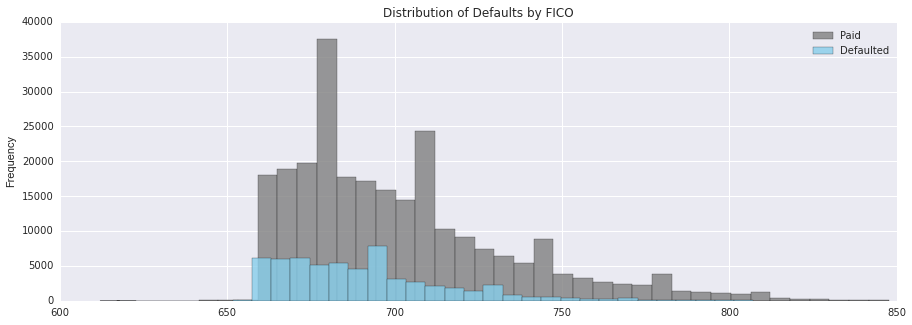

In [656]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(15, 5))
full_data[full_data['default']==0]['fico'].plot(kind='hist', bins=40, label='Paid', color='gray', alpha=0.8,title='Distribution of Defaults by FICO')
full_data[full_data['default']==1]['fico'].plot(kind='hist', bins=40, label='Defaulted', color='skyblue', alpha=0.8)
plt.legend(loc='best')
;

''

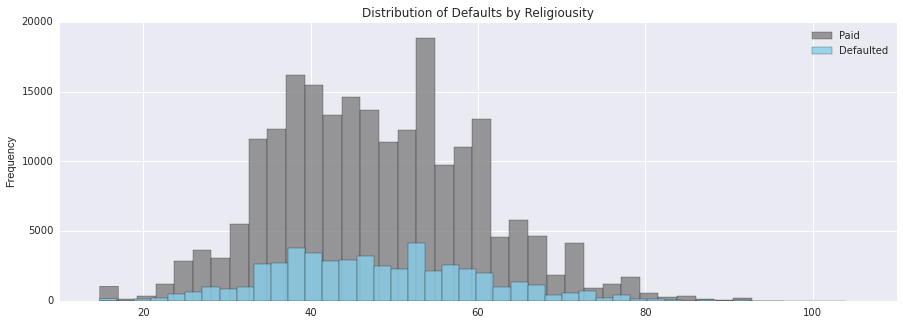

In [711]:
plt.rc('figure', figsize=(15, 5))
full_data[full_data['default']==0]['Adherents %'].plot(kind='hist', bins=40, label='Paid', color='gray', alpha=0.8,title='Distribution of Defaults by Religiousity')
full_data[full_data['default']==1]['Adherents %'].plot(kind='hist', bins=40, label='Defaulted', color='skyblue', alpha=0.8)
#print full_data.groupby(['Adherents %'])[['default']].mean()
plt.legend(loc='best')
;

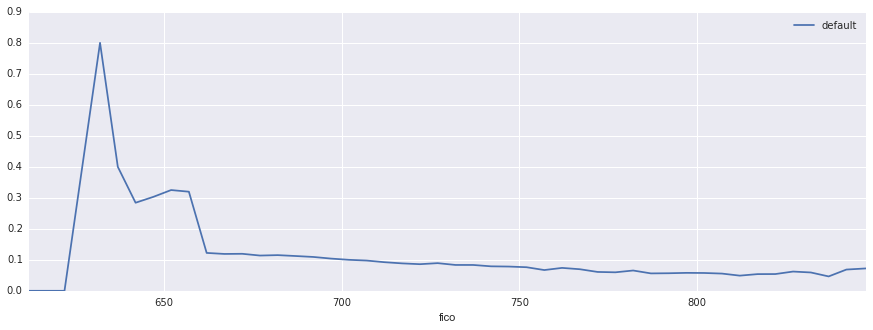

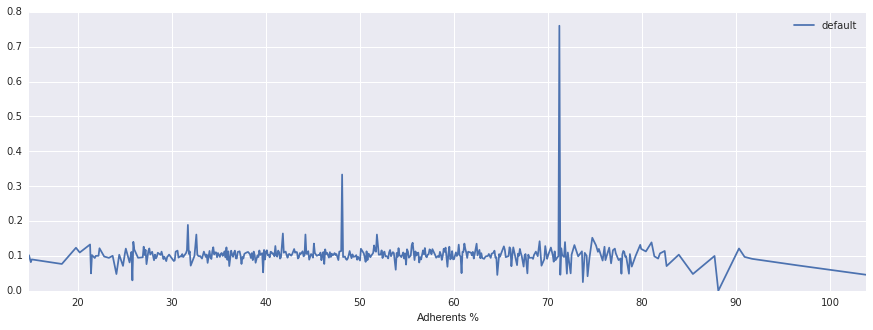

In [718]:
plt.rc('figure', figsize=(15, 5))
full_data.groupby(['fico'])[['default']].mean().plot()
full_data.groupby(['Adherents %'])[['default']].mean().plot(label = 'a');
# df.groupby("Adherents %").mean()

''

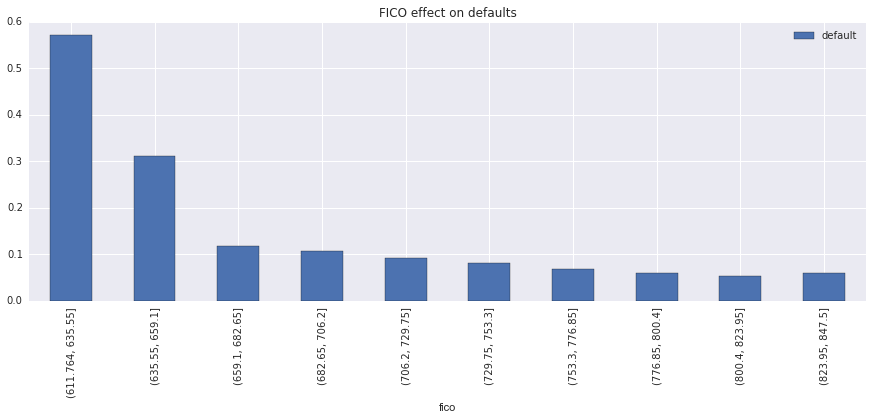

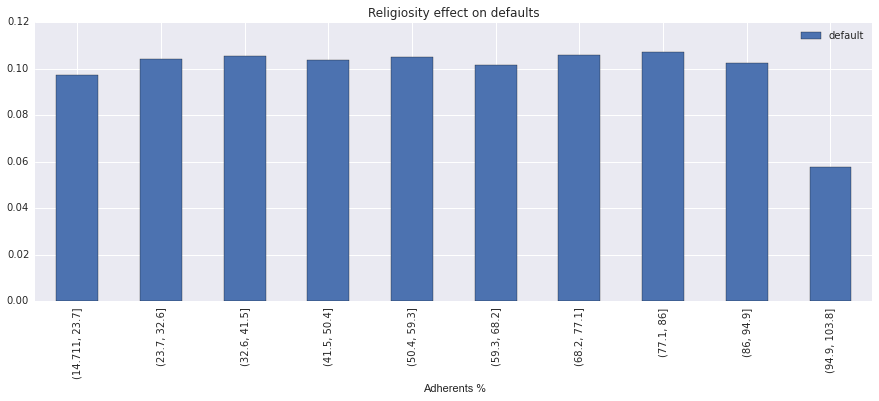

In [723]:
plt.rc('figure', figsize=(15, 5))
age_averaged = full_data.loc[:,['default']].groupby(pd.cut(full_data['fico'],10)).mean().plot(kind = 'bar', title = 'FICO effect on defaults')
age_averaged = full_data.loc[:,['default']].groupby(pd.cut(full_data['Adherents %'],10)).mean().plot(kind = 'bar', title = 'Religiosity effect on defaults')
plt.legend(loc='best')
;

In [657]:
pd.unique(past_loans['issue_d'])

array(['2011-11-30T19:00:00.000000000-0500',
       '2011-10-31T20:00:00.000000000-0400',
       '2011-09-30T20:00:00.000000000-0400',
       '2011-08-31T20:00:00.000000000-0400',
       '2011-07-31T20:00:00.000000000-0400',
       '2011-06-30T20:00:00.000000000-0400',
       '2011-05-31T20:00:00.000000000-0400',
       '2011-04-30T20:00:00.000000000-0400',
       '2011-03-31T20:00:00.000000000-0400',
       '2011-02-28T19:00:00.000000000-0500',
       '2011-01-31T19:00:00.000000000-0500',
       '2010-12-31T19:00:00.000000000-0500',
       '2010-11-30T19:00:00.000000000-0500',
       '2010-10-31T20:00:00.000000000-0400',
       '2010-09-30T20:00:00.000000000-0400',
       '2010-08-31T20:00:00.000000000-0400',
       '2010-07-31T20:00:00.000000000-0400',
       '2010-06-30T20:00:00.000000000-0400',
       '2010-05-31T20:00:00.000000000-0400',
       '2010-04-30T20:00:00.000000000-0400',
       '2010-03-31T20:00:00.000000000-0400',
       '2010-02-28T19:00:00.000000000-0500',
       '20

In [658]:
#full_data.to_csv('full_data.csv')

# Build a data set with rows for every month to current

# Create dependent and independent data

In [659]:
import numpy as np
full_data = full_data[np.isfinite(full_data['Adherents %'])]
X = full_data[['dti', 'fico', 'Adherents %', 'loan_amnt', 'annual_inc', 'ranked_sub_grade', 'employment']]
#X = full_data[['Adherents %']]
y = full_data['default']

# Split into training and test data

In [660]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# 10 cross validation iterations with 20% test / 80% train
from sklearn.cross_validation import ShuffleSplit
cv = ShuffleSplit(X_train.shape[0], n_iter=10, test_size=0.2, random_state=0)

In [661]:
y_train.mean()

0.10393087311959127

In [662]:
y_test.mean()

0.10525859255383135

In [663]:
X_train.isnull().values.any()

False

In [664]:
full_data['dti'].count()

870169

In [665]:
full_data['fico'].count()

870169

In [666]:
full_data['Adherents %'].count()

870169

In [667]:
full_data['loan_amnt'].count()

870169

In [668]:
full_data['annual_inc'].count()

870169

In [669]:
full_data['ranked_sub_grade'].count()

870169

In [670]:
full_data['employment'].count()

870169

# Standardize the data

In [672]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
# transform our training features
X_train_std = stdsc.fit_transform(X_train)
# transform the testing features in the same way
X_test_std = stdsc.transform(X_test)

# Build models
We need to evaluate:
- Is religiousity a useful predictor of loan repayment?
- Is religiousity useful when possibly confounding factors (like FICO score) are included?
- If so, are religious people more likely to repay loans?

We need models that are:
- Predictive of classification for "Charged Off" / "Fully Paid"
- Easily interpreted features, particularly "Adherents %" (religiousity)
- Scorable to compare Type I / Type II error at different thresholds

Therefore, we will only build **logistic regressions**. More sophisticated models, such as Naive Bayes or Random Forest may provide a more accurate prediction, but can't answer our question.

In [682]:
# Drop all features
lr_none = LogisticRegression(C= .00001, class_weight=None, penalty="l1") 
lr_none.fit(X_train_std, y_train.apply(np.round))

# Drop the least predictive feature (turns out to be adherents)
lr_all_but_adherents = LogisticRegression(C= .05, class_weight=None, penalty="l1") 
lr_all_but_adherents.fit(X_train_std, y_train.apply(np.round))

# include all features
lr_all = LogisticRegression(C= .5, class_weight=None, penalty="l1") 
lr_all.fit(X_train_std, y_train.apply(np.round))

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

# Evaluate F1 scores
My first instinct was to check f1-score (a blend of precision and recall). Especially important is recall - how many of the defaults are found.

This provided unexpected results: my f1-score was 93%, regardless of model. I even got the same result when I passed an array of zeros as my prediction.

What happened? The best model predicted probability of default on individual loans between 0.14% and 41.8%. Since each of these probabilities was below 50%, every single case was predicted to pay.

**Evaluation metrics to distinguish good from naive models**
- Balanced data set: we could select test data that has more defaults. However, because each test case would still be predicted to pay, the F1-scores would remain constant at a different number.
- Manually create comparison with a different threshold (if models are forced to choose "default" at probability > 15%, which model is best?): this will provide useful information, but is a crude measure at a single threshold.
- ROC score: checks across entire range of probailities

In [688]:
from sklearn.metrics import classification_report
print classification_report(lr_none.predict(X_test_std), y_test.apply(np.round), digits = 5)

             precision    recall  f1-score   support

        0.0    1.00000   0.92613   0.96165    217543
        1.0    0.00000   0.00000   0.00000         0

avg / total    1.00000   0.92613   0.96165    217543



In [689]:
print classification_report(lr_all_but_adherents.predict(X_test_std), y_test.apply(np.round), digits = 5)

             precision    recall  f1-score   support

        0.0    1.00000   0.92613   0.96165    217543
        1.0    0.00000   0.00000   0.00000         0

avg / total    1.00000   0.92613   0.96165    217543



In [728]:
# test if we simply predict 0 (no default) every time
junk = np.empty(217543)
junk.fill(0)
print classification_report(junk, y_test.apply(np.round), digits = 5)

             precision    recall  f1-score   support

        0.0    1.00000   0.92613   0.96165    217543
        1.0    0.00000   0.00000   0.00000         0

avg / total    1.00000   0.92613   0.96165    217543



In [692]:
print classification_report(lr_all.predict(X_test_std), y_test.apply(np.round), digits = 5)

             precision    recall  f1-score   support

        0.0    1.00000   0.92613   0.96165    217543
        1.0    0.00000   0.00000   0.00000         0

avg / total    1.00000   0.92613   0.96165    217543



In [516]:
# what is the range of predicted probabilities?
min(lr_all.predict_proba(X_test_std)[:,1]), max(lr_all.predict_proba(X_test_std)[:,1])

(0.0014434724893756521, 0.41800148062347503)

# Evaluate ROC scores for the three models
ROC measures true positives vs false positives as you move along the spectrum of probabilities. A higher area under the curve indicates the model makes better predictions (50% is random).

ROC is especially important for default:
- Capable of evaluating models that predict events that are individually low-probability, like loan defaults
- Evaluates across the entire spectrum of predictions. Since investors are interested in both safe and risky loans (if the interest rate compensates for losses), accuracy across the spectrum is useful.

**Results**
- The naive model scores 50% (random)
- The model with all factors but Adherents performs much better: 64.39%
- The model improves slightly (64.44%) when we add the Adherents feature. **Conclusion: this feature adds some predictiveness.**

In [683]:
from sklearn.metrics import roc_auc_score
# roc_auc_score(y_test, lr_none.predict_proba(X_test_std)[:,1])
roc_auc_score(y_test.apply(np.round), lr_none.predict_proba(X_test_std)[:,1])

0.5

In [684]:
roc_auc_score(y_test.apply(np.round), lr_all_but_adherents.predict_proba(X_test_std)[:,1])

0.66838402202625202

In [685]:
roc_auc_score(y_test.apply(np.round), lr_all.predict_proba(X_test_std)[:,1])

0.66838582471089836

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


##############################################################################
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Examine model coefficients
Almost all coefficients can be easily interpreted intuitively:
- dti: positive because more debt implies more defaults
- fico: negative because higher score implies fewer defaults
- loan_amnt: positive because bigger loan implies more defaults
- annual_inc: negative because more salary implies fewer defaults
- ranked_sub_grade: positive because worse LC risk grade implies more defaults
- employment: positive (weird because I expected more years in the same role implies fewer defaults)

Conclusion:
- adherents: negative - higher religiousity implies fewer defaults

In [496]:
pd.DataFrame({'features': X_train.columns, 'coefficients': lr_none.coef_[0]})

,coefficients,features
0,0,dti
1,0,fico
2,0,Adherents %
3,0,loan_amnt
4,0,annual_inc
5,0,ranked_sub_grade
6,0,employment


In [497]:
pd.DataFrame({'features': X_train.columns, 'coefficients': lr_all_but_adherents.coef_[0]})

,coefficients,features
0,0.053639,dti
1,-0.128155,fico
2,0.000000,Adherents %
3,0.001957,loan_amnt
4,-0.280748,annual_inc
5,0.311255,ranked_sub_grade
6,0.035417,employment


In [498]:
pd.DataFrame({'features': X_train.columns, 'coefficients': lr_all.coef_[0]})

,coefficients,features
0,0.059471,dti
1,-0.160048,fico
2,-0.010151,Adherents %
3,0.034970,loan_amnt
4,-0.330274,annual_inc
5,0.302917,ranked_sub_grade
6,0.052459,employment


# Todos
I'm taking various shortcuts to arrive at an answer. When there's time to expand my analysis, revisit these issues:
- Looked at data that was old enough to have all matured or defaulted. 
  - Must add records for each month to default or current date to determine shape of default curve and then apply this as a multiplicative factor to features
  - Use likelihood of default to convert intermediate statuses (late, grace period, etc) to y
- Only used loans from Zip3 areas that have a zip code ending in "01" (example: 077XX -> 07701)
  - Substitute "02" in records that don't align?
- Used a small subset of available fields
  - Add more features
  - Add political affiliation and ruralness to eliminate more confounding factors
- Maybe there's some kind of autoregression to look at recent credit experience for other loans
- cross-validation with roc http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#example-model-selection-plot-roc-crossval-py
- Use nearest neighbors on FICO score and geography, particularly in combination with ARIMA

## Fill in rows for each date to last payment
A simple look at the data will be skewed because active loans may still default in the future. Only using 2012 36 month loans.

The data is supplied with status for each loan. Best to fill data with records for each month from loan start (and status = current) until today or last payment). This will allow me to determine the shape of the conditional default curve (what percentage of current loans default vs age?) and then use the current data set. I will also gain a better understanding of Loss Given Default for this data set.

Not sure if I have time to make this happen. When I do, I will go back and import data from 2013+.

In [334]:
# What are all the dates in the table?
# for each date, what are the earlier dates
# create new table with "current" until paid or written off
# table should stop before defaults and late payments start registering
#all_dates = pd.DataFrame(index=pd.unique(past_loans.sort_values('last_pymnt_d')['last_pymnt_d']))#, columns='date_d')
#all_dates['report_d'] = pd.unique(past_loans.sort_values('last_pymnt_d')['last_pymnt_d'])
#all_dates['common'] = 1
#all_dates.dropna(how = 'any')
#all_dates[(pd.notnull(all_dates['report_d']))]
# ro's idea - just loop through the data to create the data

# past_loans['common'] = 1
# partly_merged = pd.merge(past_loans, all_dates, on = 'common')
# full_past_loans = partly_merged[(partly_merged['last_pymnt_d'] >= partly_merged['report_d'] & 
#                                 pd.notnull(partly_merged['report_d']))]
# full_past_loans.head(100)